# Anonymization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import hashlib
import datetime

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


Utilizaremos un conjunto de datos sintético de observaciones de signos vitales de pacientes.

In [2]:
data = pd.read_csv("data/observations.csv",parse_dates=["birth_date", "observation_date"])

Nuestro conjunto de datos contiene una serie de características que podrían categorizarse como datos personales o sensibles.

El nombre y el rut podrían son datos personales que no debiésemos tener acceso, pero son necesarios para la identificación de sujetos dentro del conjunto de datos y para realizar posibles cruces con otras tablas de datos.

Si bien las fechas asociadas al paciente y a las observaciones no nos permiten realizar una detección precisa de la persona a la que pertenecen las instancias de datos, este dato se considera información protegida de salud. No nos interesan las fechas exactas asociadas, pero si nos interesan los delta de tiempo entre observaciones.

Estos dos tipos de datos descritos anteriormente son información protegida, pero de todos modos es información clave para la generación de conclusiones, por lo que no se pueden eliminar, por ende debemos encontrar una solución que nos permita trabajar con estas características sin vulnerar la privacidad del paciente.

In [3]:
data

,name,rut,gender,birth_date,observation_date,heart_rate,diastolic_blood_pressure,systolic_blood_pressure
0,Gaspar Matías Meza Alfaro,19080686-3,male,1973-04-07,1989-06-06,91,66.5,93.9
1,Lucas Matías Herrera Romero,15725416-2,male,2009-12-26,2018-08-31,85,86.5,123.5
2,Gaspar Matías Meza Alfaro,19080686-3,male,1973-04-07,1975-07-12,92,79.2,112.4
3,Leonor Sofía Morales Navarro,19530830-6,female,1973-08-15,2019-04-21,77,95.0,136.6
4,Maite Maite Ojeda Fuentealba,19943131-5,female,2012-05-12,2021-06-20,67,77.4,109.8
...,...,...,...,...,...,...,...,...
952,Luciano José Salgado Espinoza,14912860-3,male,1974-07-09,2003-09-27,89,88.3,124.8
953,Martina Emma Lara Gaete,17600320-0,female,2019-12-16,2020-11-25,72,91.1,128.1
954,Maite Maite Ojeda Fuentealba,19943131-5,female,2012-05-12,2016-03-17,65,90.6,129.1
955,Julián Matías Quiroz Alvarado,16516966-2,male,2004-07-18,2015-04-17,90,91.2,128.5


Calculamos la edad que tiene el paciente en cada observación.

In [4]:
data["age"] = (data.observation_date - data.birth_date).dt.days / 365.25
data

,name,rut,gender,birth_date,observation_date,heart_rate,diastolic_blood_pressure,systolic_blood_pressure,age
0,Gaspar Matías Meza Alfaro,19080686-3,male,1973-04-07,1989-06-06,91,66.5,93.9,16.164271
1,Lucas Matías Herrera Romero,15725416-2,male,2009-12-26,2018-08-31,85,86.5,123.5,8.678987
2,Gaspar Matías Meza Alfaro,19080686-3,male,1973-04-07,1975-07-12,92,79.2,112.4,2.261465
3,Leonor Sofía Morales Navarro,19530830-6,female,1973-08-15,2019-04-21,77,95.0,136.6,45.681040
4,Maite Maite Ojeda Fuentealba,19943131-5,female,2012-05-12,2021-06-20,67,77.4,109.8,9.106092
...,...,...,...,...,...,...,...,...,...
952,Luciano José Salgado Espinoza,14912860-3,male,1974-07-09,2003-09-27,89,88.3,124.8,29.218344
953,Martina Emma Lara Gaete,17600320-0,female,2019-12-16,2020-11-25,72,91.1,128.1,0.944559
954,Maite Maite Ojeda Fuentealba,19943131-5,female,2012-05-12,2016-03-17,65,90.6,129.1,3.846680
955,Julián Matías Quiroz Alvarado,16516966-2,male,2004-07-18,2015-04-17,90,91.2,128.5,10.746064


Agrupamos por paciente y diagnosticamos a cada paciente con hipertensión.

In [5]:
hypertension = data.groupby(by=["name"])[["heart_rate","diastolic_blood_pressure","systolic_blood_pressure"]].mean()
hypertension["hypertension"] = hypertension.systolic_blood_pressure > 130
hypertension

,heart_rate,diastolic_blood_pressure,systolic_blood_pressure,hypertension
name,,,,
Agustina Renata Correa Salinas,70.052632,85.784211,120.576316,False
Gabriel Gaspar Lobos Zuñiga,67.909091,85.572727,120.972727,False
Gaspar Matías Meza Alfaro,89.840909,85.960227,121.500000,False
Isabella Sofía Guerrero Perez,68.863636,86.381818,121.800000,False
José Benjamín Alvarado Becerra,73.000000,78.000000,107.100000,False
Julián Matías Quiroz Alvarado,88.611111,84.000000,118.607407,False
Leonor Sofía Morales Navarro,69.820000,87.746000,123.816000,False
Lucas Joaquín Donoso Tapia,90.093750,85.318750,120.525000,False
Lucas Matías Herrera Romero,90.032258,84.080645,118.632258,False


Exploramos si existe una correlación entre las observaciones y el género del paciente.

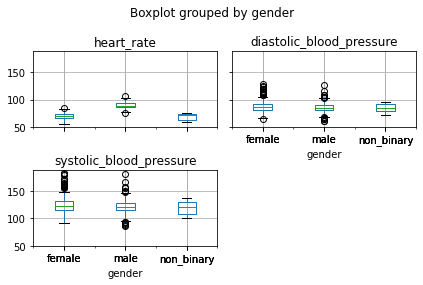

In [6]:
data.boxplot(column=["heart_rate","diastolic_blood_pressure","systolic_blood_pressure"], by="gender")
plt.tight_layout()
plt.show()

Exploramos si existe una correlación entre la presión arterial y la edad de los pacientes.

<AxesSubplot:xlabel='age', ylabel='diastolic_blood_pressure'>

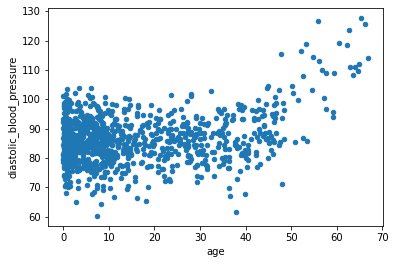

In [7]:
data.plot.scatter(x="age", y="diastolic_blood_pressure")

## Anonimización

Debemos encontrar una forma de codificar la información protegida de los pacientes de una manera que se mantenga la biyección entre la forma bruta y anonimizada de los datos, sin vulnerar la privacidad del paciente y sin que se pueda deidentificar la información. Una de los métodos que cumple todos estos requisitos son las funciones hash.

> Una función resumen, en inglés hash function, también conocida con el híbrido función hash, convierte un elemento u elementos de entrada a una función en otro elemento. También se las conoce como función extracto, del inglés digest function, función de extractado y por el híbrido función digest.
>
> Wikipedia - Función hash

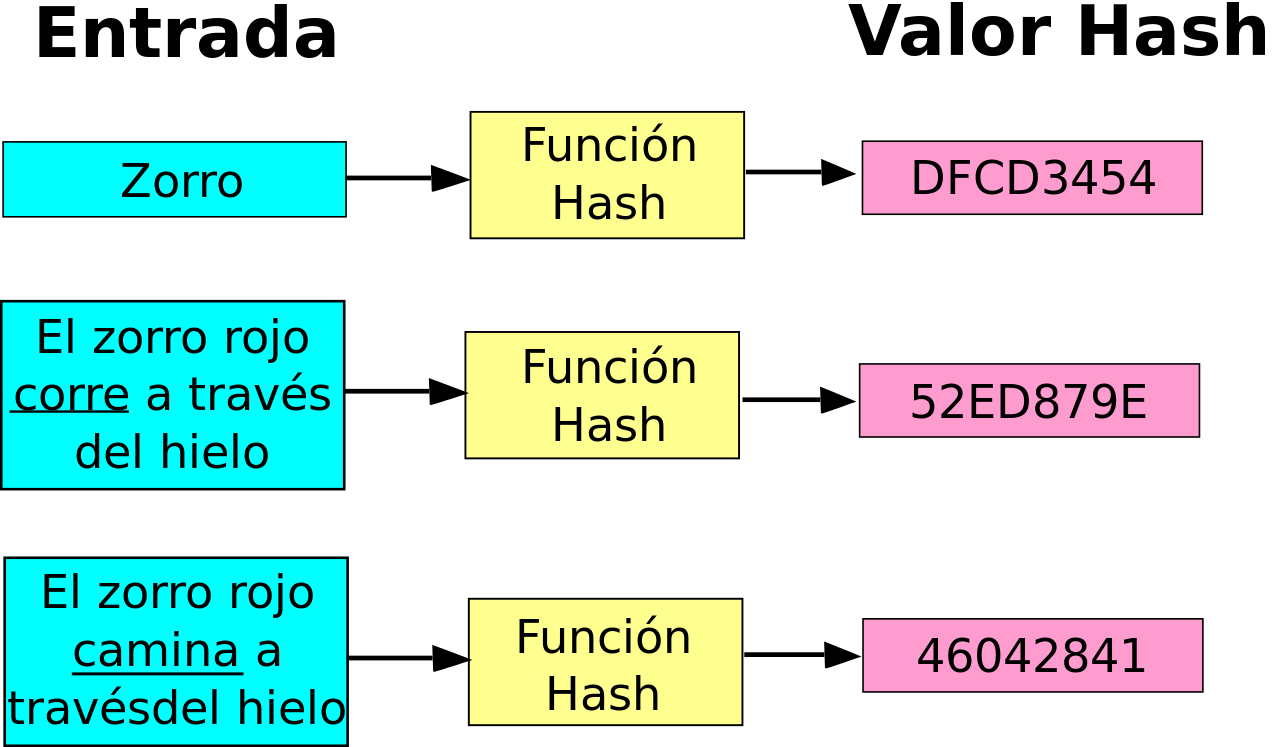

In [8]:
rut = "1900686-3"

In [9]:
hashed_rut = hashlib.md5( # Con esta función podemos hash un objeto
    rut.encode() # Debemos convertir el objeto en su representación binaria
).hexdigest() # Obtenemos el hash del objeto (número hexadecimal)

In [10]:
hashed_rut

'58a62f704b9b1b20b8ababa6b8291d88'

Podemos también representar nuestro hash como un en base decimal

In [11]:
int(hashed_rut, 16)

117834947077793838774125733465157082504

Para obtener un entero decimal más corto, podemos truncar nuestra representación hexadecimal y después convertirla a decimal.

In [12]:
int(hashed_rut[:3], 16)

1418

In [13]:
def hasher(x,output="hex"):
    """Esta función recibe un string y lo convierte en su hash decimal o hexadecimal"""
    encoded_string = x.encode()
    hashed_string = hashlib.md5(encoded_string)
    hashed_hex = hashed_string.hexdigest()
    if output == "int":
        hashed_int = int(hashed_hex[:3], 16)
        return hashed_int
    if output == "hex":
        return hashed_hex

In [14]:
hasher(rut)

'58a62f704b9b1b20b8ababa6b8291d88'

In [15]:
hasher(rut, output="int")

1418

Ahora procedemos a anonimizar nuestro conjunto de datos.

In [16]:
anonymized_data = data.copy()

Primero simplemente eliminamos el nombre del paciente

In [17]:
anonymized_data["name"] = pd.NA
anonymized_data

,name,rut,gender,birth_date,observation_date,heart_rate,diastolic_blood_pressure,systolic_blood_pressure,age
0,<NA>,19080686-3,male,1973-04-07,1989-06-06,91,66.5,93.9,16.164271
1,<NA>,15725416-2,male,2009-12-26,2018-08-31,85,86.5,123.5,8.678987
2,<NA>,19080686-3,male,1973-04-07,1975-07-12,92,79.2,112.4,2.261465
3,<NA>,19530830-6,female,1973-08-15,2019-04-21,77,95.0,136.6,45.681040
4,<NA>,19943131-5,female,2012-05-12,2021-06-20,67,77.4,109.8,9.106092
...,...,...,...,...,...,...,...,...,...
952,<NA>,14912860-3,male,1974-07-09,2003-09-27,89,88.3,124.8,29.218344
953,<NA>,17600320-0,female,2019-12-16,2020-11-25,72,91.1,128.1,0.944559
954,<NA>,19943131-5,female,2012-05-12,2016-03-17,65,90.6,129.1,3.846680
955,<NA>,16516966-2,male,2004-07-18,2015-04-17,90,91.2,128.5,10.746064


El hash del rut en su representación hexadecimal lo vamos a utilizar como identificador de cada sujeto.

In [18]:
anonymized_data["hashed_rut"] = anonymized_data.rut.apply(hasher)
anonymized_data

,name,rut,gender,birth_date,observation_date,heart_rate,diastolic_blood_pressure,systolic_blood_pressure,age,hashed_rut
0,<NA>,19080686-3,male,1973-04-07,1989-06-06,91,66.5,93.9,16.164271,391506dfddf9b05bcd2eb5747f9f7e4c
1,<NA>,15725416-2,male,2009-12-26,2018-08-31,85,86.5,123.5,8.678987,c2dd8f8812c656a114154de7a125de3e
2,<NA>,19080686-3,male,1973-04-07,1975-07-12,92,79.2,112.4,2.261465,391506dfddf9b05bcd2eb5747f9f7e4c
3,<NA>,19530830-6,female,1973-08-15,2019-04-21,77,95.0,136.6,45.681040,63a8735850a6e3b85e1b4a50ca2b2faa
4,<NA>,19943131-5,female,2012-05-12,2021-06-20,67,77.4,109.8,9.106092,8d67da03acf8241d50228ce96968411c
...,...,...,...,...,...,...,...,...,...,...
952,<NA>,14912860-3,male,1974-07-09,2003-09-27,89,88.3,124.8,29.218344,6409eca8d4f823db005e6f4a0592227d
953,<NA>,17600320-0,female,2019-12-16,2020-11-25,72,91.1,128.1,0.944559,f1419f3acd2332d9dee183d19563f080
954,<NA>,19943131-5,female,2012-05-12,2016-03-17,65,90.6,129.1,3.846680,8d67da03acf8241d50228ce96968411c
955,<NA>,16516966-2,male,2004-07-18,2015-04-17,90,91.2,128.5,10.746064,38e4ab0fa1fc17966dbac2c2934a5a72


Como somos capaces de generar un hash del rut en su representación decimal, este valor lo utilizaremos para deidentificar las fechas al sumarle la representación decimal del hash (em días) a las fechas asociadas al sujeto. Con esto no utilizamos las fechas reales, pero la deidentifcación de las fechas es consistente a lo largo de todas las observaciones del sujeto.

In [19]:
anonymized_data["birth_date"] = anonymized_data.apply(lambda x: x["birth_date"] + datetime.timedelta(days=hasher(x["rut"], output="int")), axis=1)
anonymized_data["observation_date"] = anonymized_data.apply(lambda x: x["observation_date"] + datetime.timedelta(days=hasher(x["rut"], output="int")), axis=1)
anonymized_data["age"] = (anonymized_data.observation_date - anonymized_data.birth_date).dt.days / 365.25
anonymized_data

,name,rut,gender,birth_date,observation_date,heart_rate,diastolic_blood_pressure,systolic_blood_pressure,age,hashed_rut
0,<NA>,19080686-3,male,1975-10-07,1991-12-06,91,66.5,93.9,16.164271,391506dfddf9b05bcd2eb5747f9f7e4c
1,<NA>,15725416-2,male,2018-07-09,2027-03-14,85,86.5,123.5,8.678987,c2dd8f8812c656a114154de7a125de3e
2,<NA>,19080686-3,male,1975-10-07,1978-01-10,92,79.2,112.4,2.261465,391506dfddf9b05bcd2eb5747f9f7e4c
3,<NA>,19530830-6,female,1977-12-26,2023-09-01,77,95.0,136.6,45.681040,63a8735850a6e3b85e1b4a50ca2b2faa
4,<NA>,19943131-5,female,2018-07-22,2027-08-30,67,77.4,109.8,9.106092,8d67da03acf8241d50228ce96968411c
...,...,...,...,...,...,...,...,...,...,...
952,<NA>,14912860-3,male,1978-11-25,2008-02-13,89,88.3,124.8,29.218344,6409eca8d4f823db005e6f4a0592227d
953,<NA>,17600320-0,female,2030-07-11,2031-06-21,72,91.1,128.1,0.944559,f1419f3acd2332d9dee183d19563f080
954,<NA>,19943131-5,female,2018-07-22,2022-05-27,65,90.6,129.1,3.846680,8d67da03acf8241d50228ce96968411c
955,<NA>,16516966-2,male,2007-01-14,2017-10-13,90,91.2,128.5,10.746064,38e4ab0fa1fc17966dbac2c2934a5a72


Eliminamos la columna de rut.

In [20]:
anonymized_data = anonymized_data.drop("rut",axis=1)

In [21]:
hypertension_anonymized = anonymized_data.groupby(by=["hashed_rut"])[["heart_rate","diastolic_blood_pressure","systolic_blood_pressure"]].mean()
hypertension_anonymized["hypertension"] = hypertension_anonymized.systolic_blood_pressure > 130
hypertension_anonymized

,heart_rate,diastolic_blood_pressure,systolic_blood_pressure,hypertension
hashed_rut,,,,
38e4ab0fa1fc17966dbac2c2934a5a72,88.611111,84.000000,118.607407,False
391506dfddf9b05bcd2eb5747f9f7e4c,89.840909,85.960227,121.500000,False
5c944e943c810e768a4f085c7b620da5,85.272727,87.227273,122.927273,False
5cb72e2d4909b48b443289ac96a66020,68.863636,86.381818,121.800000,False
5e3556a3a80cc92ff7fd22e669530ccc,69.916667,85.047917,119.729167,False
63a8735850a6e3b85e1b4a50ca2b2faa,69.820000,87.746000,123.816000,False
6409eca8d4f823db005e6f4a0592227d,90.208791,84.902198,119.651648,False
8119124e34f3e29fd3c83b9b9eaa177e,68.375000,84.250000,118.481250,False
8d67da03acf8241d50228ce96968411c,69.462366,86.963441,122.786022,False


Verificamos que llegamos a las mismas conclusiones al utilizar el conjunto de datos identificado y deidentificado.

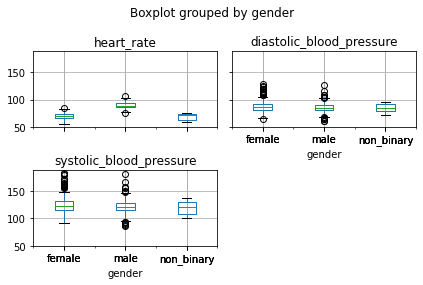

In [22]:
anonymized_data.boxplot(column=["heart_rate","diastolic_blood_pressure","systolic_blood_pressure"], by="gender")
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='age', ylabel='diastolic_blood_pressure'>

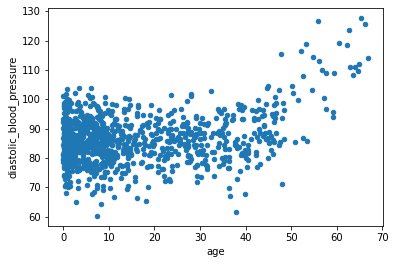

In [23]:
anonymized_data.plot.scatter(x="age", y="diastolic_blood_pressure")